In [45]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report, confusion_matrix

In [46]:
df = pd.read_csv('user_personalized_features.csv')
print("Loaded dataset with shape:", df.shape)
print("\nColumns and dtypes:")
print(df.dtypes)
print("\nFirst 5 rows:")
print(df.head().T)


Loaded dataset with shape: (1000, 15)

Columns and dtypes:
Unnamed: 0                      int64
User_ID                        object
Age                             int64
Gender                         object
Location                       object
Income                          int64
Interests                      object
Last_Login_Days_Ago             int64
Purchase_Frequency              int64
Average_Order_Value             int64
Total_Spending                  int64
Product_Category_Preference    object
Time_Spent_on_Site_Minutes      int64
Pages_Viewed                    int64
Newsletter_Subscription          bool
dtype: object

First 5 rows:
                                    0            1         2         3  \
Unnamed: 0                          0            1         2         3   
User_ID                            #1           #2        #3        #4   
Age                                56           46        32        60   
Gender                           Male       Fe

In [47]:
target_col = "Total_Spending"

# Drop known ID / index columns
id_like_cols = [c for c in df.columns if "id" in c.lower() or "unnamed" in c.lower()]
df = df.drop(columns=id_like_cols, errors="ignore")

print("Dropped ID columns:", id_like_cols)

# ==== Define X and y ====
X = df.drop(columns=[target_col])
y = df[target_col]

Dropped ID columns: ['Unnamed: 0', 'User_ID']


In [48]:

numeric_cols = X.select_dtypes(include=[np.number]).columns.tolist()
cat_cols = X.select_dtypes(include=['object', 'category', 'bool']).columns.tolist()

# ==== Preprocessing ====
numeric_transformer = Pipeline([
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler())
])
categorical_transformer = Pipeline([
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("ord", OrdinalEncoder(handle_unknown="use_encoded_value", unknown_value=-1))
])

preprocessor = ColumnTransformer([
    ("num", numeric_transformer, numeric_cols),
    ("cat", categorical_transformer, cat_cols)
], remainder="drop")


Basic Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 17 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   Age                          1000 non-null   int64  
 1   Gender                       1000 non-null   int64  
 2   Location                     1000 non-null   int64  
 3   Income                       1000 non-null   int64  
 4   Interests                    1000 non-null   int64  
 5   Last_Login_Days_Ago          1000 non-null   int64  
 6   Purchase_Frequency           1000 non-null   int64  
 7   Average_Order_Value          1000 non-null   int64  
 8   Total_Spending               1000 non-null   int64  
 9   Product_Category_Preference  1000 non-null   object 
 10  Time_Spent_on_Site_Minutes   1000 non-null   int64  
 11  Pages_Viewed                 1000 non-null   int64  
 12  Newsletter_Subscription      1000 non-null   int64  
 13  visitor

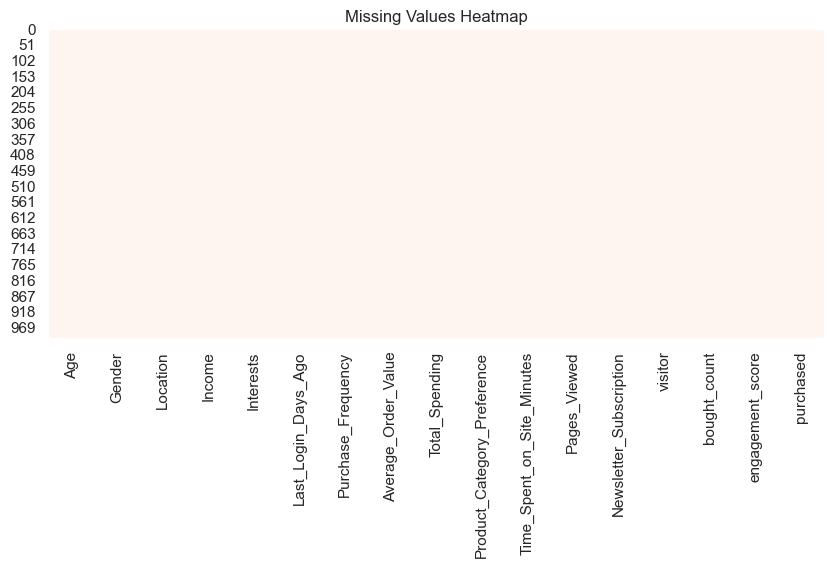

In [57]:
sns.set(style="whitegrid", palette="muted")

# 1️⃣ Check dataset overview
print("Basic Info:")
print(df.info(), "\n")

print("Summary Statistics:")
print(df.describe().T, "\n")

# 2️⃣ Visualize missing values
plt.figure(figsize=(10, 4))
sns.heatmap(df.isnull(), cbar=False, cmap='Reds')
plt.title("Missing Values Heatmap")
plt.show()

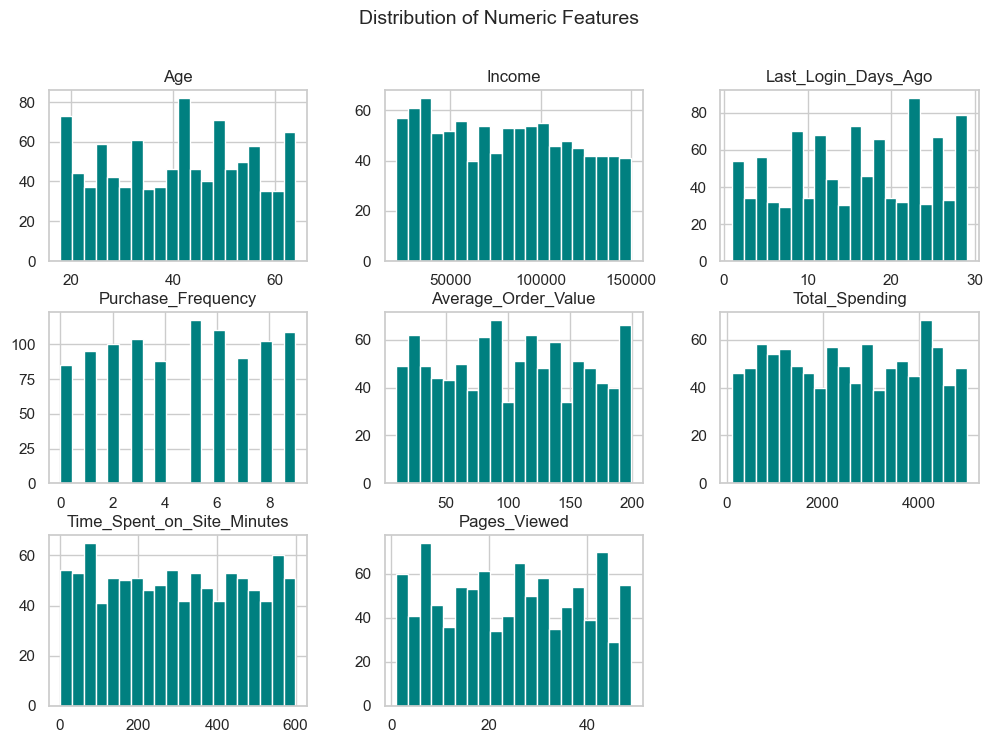

In [58]:
numeric_columns = [
    'Age', 'Income', 'Last_Login_Days_Ago', 'Purchase_Frequency',
    'Average_Order_Value', 'Total_Spending', 'Time_Spent_on_Site_Minutes', 'Pages_Viewed'
]

df[numeric_columns].hist(bins=20, figsize=(12, 8), color='teal')
plt.suptitle("Distribution of Numeric Features", fontsize=14)
plt.show()

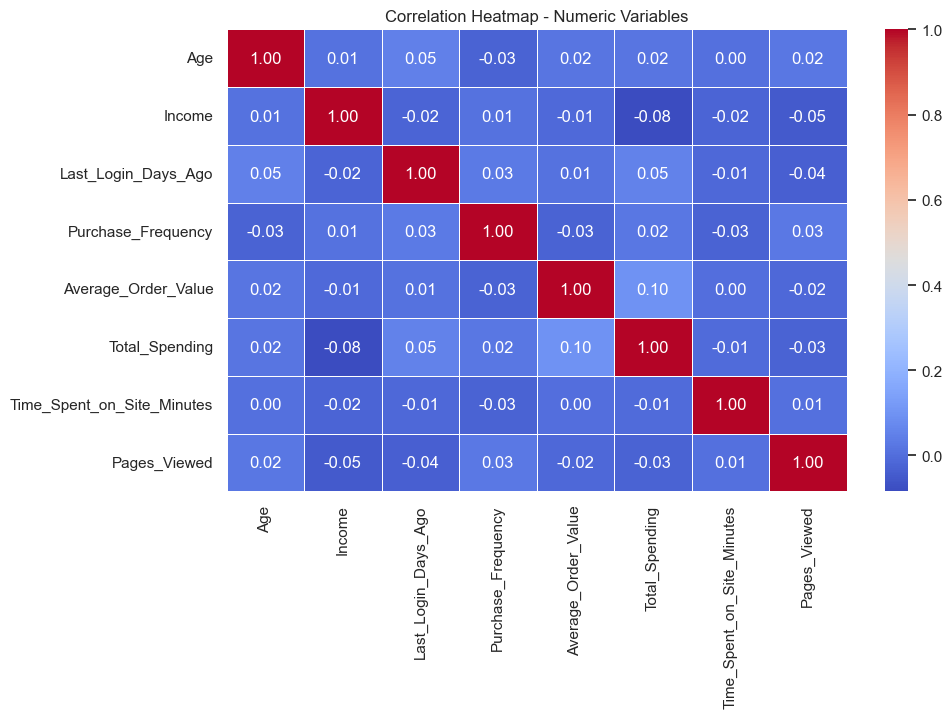

In [59]:
plt.figure(figsize=(10, 6))
sns.heatmap(df[numeric_columns].corr(), annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
plt.title("Correlation Heatmap - Numeric Variables")
plt.show()

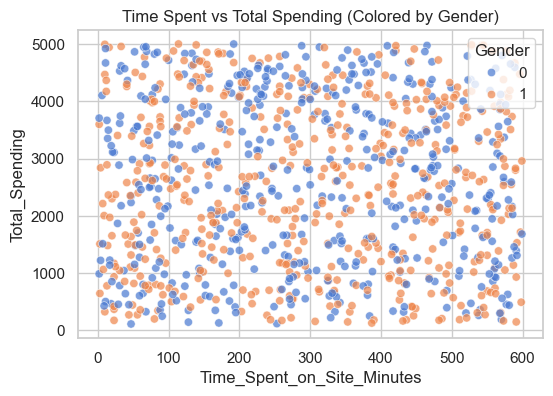

In [60]:
plt.figure(figsize=(6, 4))
sns.scatterplot(x='Time_Spent_on_Site_Minutes', y='Total_Spending', data=df, hue='Gender', alpha=0.7)
plt.title("Time Spent vs Total Spending (Colored by Gender)")
plt.show()

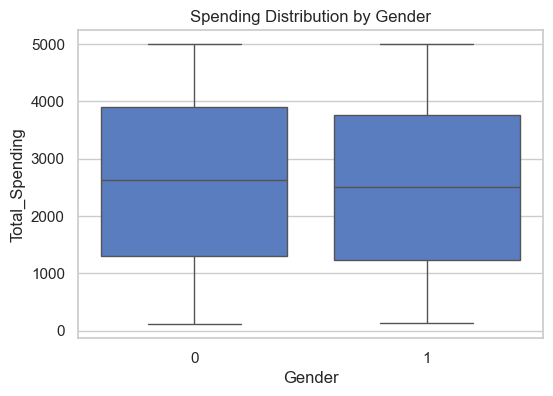

In [61]:
plt.figure(figsize=(6, 4))
sns.boxplot(x='Gender', y='Total_Spending', data=df)
plt.title("Spending Distribution by Gender")
plt.show()


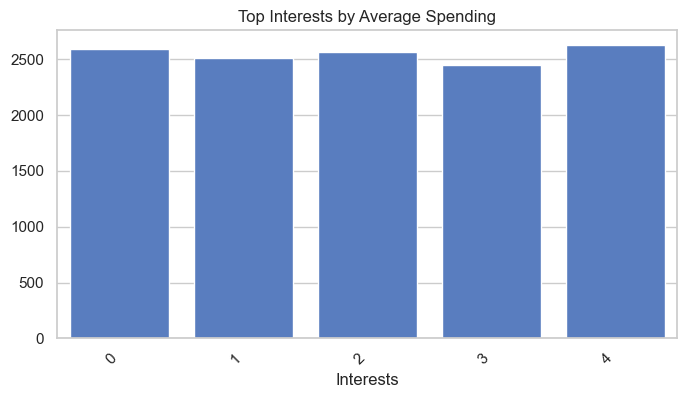

In [62]:
if 'Interests' in df.columns:
    plt.figure(figsize=(8, 4))
    top_interests = df.groupby('Interests')['Total_Spending'].mean().sort_values(ascending=False).head(10)
    sns.barplot(x=top_interests.index, y=top_interests.values)
    plt.title("Top Interests by Average Spending")
    plt.xticks(rotation=45, ha='right')
    plt.show()

In [49]:

df.fillna(0, inplace=True)

# Step 4: Encode categorical columns
categorical_columns = ['Gender', 'Location', 'Interests', 'Newsletter_Subscription']
for col in categorical_columns:
    if col in df.columns:
        encoder = LabelEncoder()
        df[col] = encoder.fit_transform(df[col])

# Step 5: Create meaningful target and behavioral features
np.random.seed(42)

# Add visitor info and purchase counts (optional behavioral features)
df['visitor'] = np.random.choice(['New', 'Returning'], size=len(df))
df['bought_count'] = np.random.randint(0, 20, size=len(df))
df['visitor'] = LabelEncoder().fit_transform(df['visitor'])


In [50]:

# ---- Create a realistic "purchased" target ----
# Engagement score combines on-site behavior and frequency
df['engagement_score'] = (
    0.4 * df['Pages_Viewed'] +
    0.3 * df['Time_Spent_on_Site_Minutes'] +
    0.3 * df['Purchase_Frequency']
)

# Normalize engagement score
df['engagement_score'] = (df['engagement_score'] - df['engagement_score'].min()) / (
    df['engagement_score'].max() - df['engagement_score'].min()
)

# Threshold: top 30% high-engagement users who also spend more than median → "purchased" = 1
threshold = df['engagement_score'].quantile(0.7)
df['purchased'] = ((df['engagement_score'] > threshold) &
                   (df['Total_Spending'] > df['Total_Spending'].median())).astype(int)

print(df['purchased'].value_counts(normalize=True))
print("✅ Target variable 'purchased' created based on engagement and spending patterns.\n")


purchased
0    0.849
1    0.151
Name: proportion, dtype: float64
✅ Target variable 'purchased' created based on engagement and spending patterns.



In [52]:
features = [
    'Age', 'Income', 'Total_Spending', 'Pages_Viewed', 'Gender', 'Location',
    'Interests', 'Newsletter_Subscription', 'Time_Spent_on_Site_Minutes',
    'Purchase_Frequency', 'Average_Order_Value', 'visitor', 'bought_count'
]
X = df[features]
y = df['purchased']



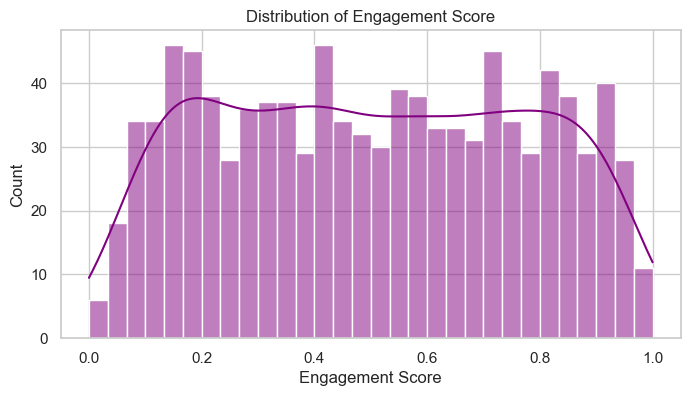

In [63]:
plt.figure(figsize=(8, 4))
sns.histplot(df['engagement_score'], bins=30, kde=True, color='purple')
plt.title("Distribution of Engagement Score")
plt.xlabel("Engagement Score")
plt.ylabel("Count")
plt.show()

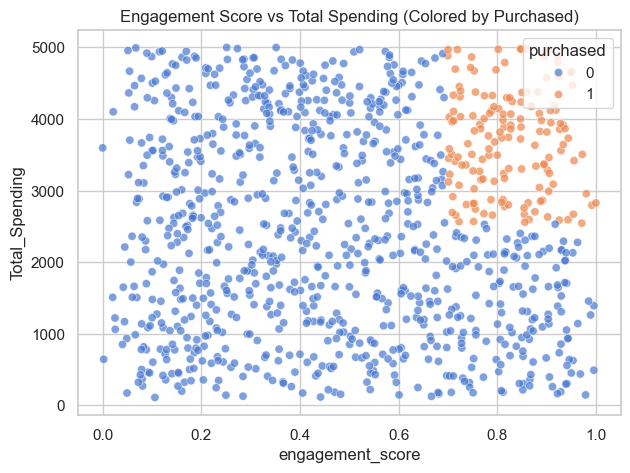

In [64]:
plt.figure(figsize=(7, 5))
sns.scatterplot(x='engagement_score', y='Total_Spending', hue='purchased', data=df, alpha=0.7)
plt.title("Engagement Score vs Total Spending (Colored by Purchased)")
plt.show()


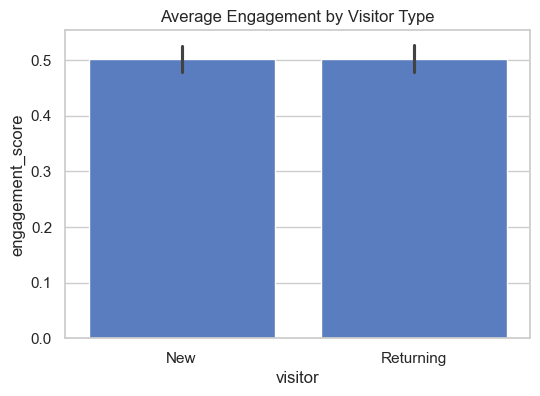

In [65]:
plt.figure(figsize=(6, 4))
sns.barplot(x='visitor', y='engagement_score', data=df)
plt.title("Average Engagement by Visitor Type")
plt.xticks([0, 1], ['New', 'Returning'])
plt.show()

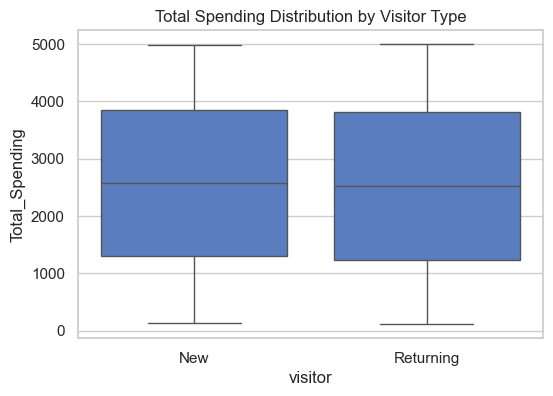

In [66]:
plt.figure(figsize=(6, 4))
sns.boxplot(x='visitor', y='Total_Spending', data=df)
plt.title("Total Spending Distribution by Visitor Type")
plt.xticks([0, 1], ['New', 'Returning'])
plt.show()


/var/folders/fk/jlnc53c50rg4mqq9m28fkq380000gn/T/ipykernel_2762/570054929.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='purchased', data=df, palette='viridis')


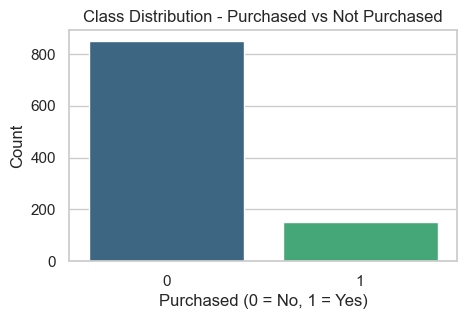

In [67]:
plt.figure(figsize=(5, 3))
sns.countplot(x='purchased', data=df, palette='viridis')
plt.title("Class Distribution - Purchased vs Not Purchased")
plt.xlabel("Purchased (0 = No, 1 = Yes)")
plt.ylabel("Count")
plt.show()

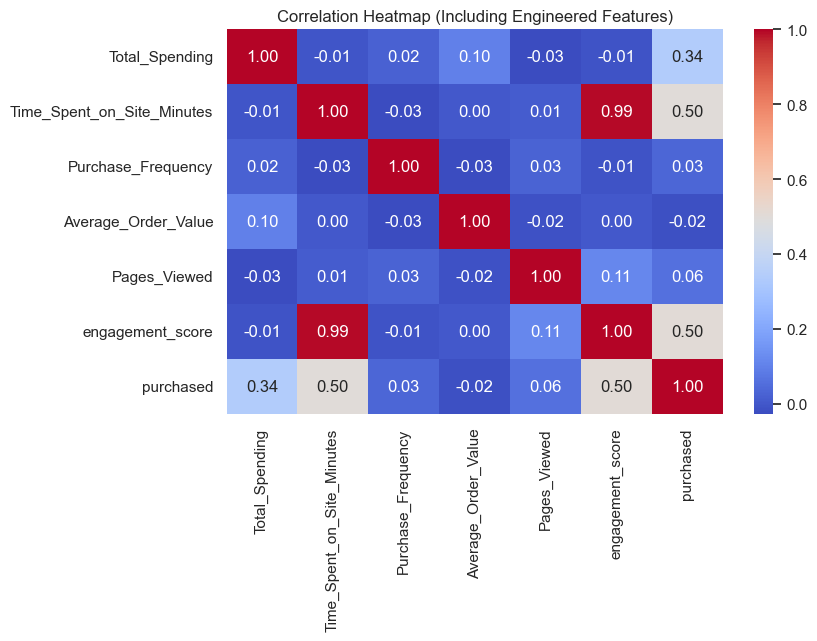

In [68]:
important_features = [
    'Total_Spending', 'Time_Spent_on_Site_Minutes', 'Purchase_Frequency',
    'Average_Order_Value', 'Pages_Viewed', 'engagement_score', 'purchased'
]

plt.figure(figsize=(8, 5))
sns.heatmap(df[important_features].corr(), annot=True, cmap='coolwarm', fmt='.2f')
plt.title("Correlation Heatmap (Including Engineered Features)")
plt.show()

In [53]:
# Step 7: Scale features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Step 8: Split data
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.3, random_state=42, stratify=y
)


In [54]:
# Step 9: Define models
models = {
    "SVM": SVC(kernel='linear', random_state=42),
    "Random Forest": RandomForestClassifier(n_estimators=100, random_state=42),
    "Gradient Boosting": GradientBoostingClassifier(random_state=42)
}

In [55]:
# Step 10: Train, predict, and evaluate
results = []
for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    results.append({
        "Model": name,
        "Accuracy": accuracy_score(y_test, y_pred),
        "Precision": precision_score(y_test, y_pred, zero_division=0),
        "Recall": recall_score(y_test, y_pred, zero_division=0),
        "F1-Score": f1_score(y_test, y_pred, zero_division=0)
    })
    print(f"\n=== {name} Classification Report ===")
    print(classification_report(y_test, y_pred, zero_division=0))

# Step 11: Model Comparison
results_df = pd.DataFrame(results)
print("\nModel Performance Comparison:\n")
print(results_df)



=== SVM Classification Report ===
              precision    recall  f1-score   support

           0       0.96      0.97      0.96       255
           1       0.83      0.76      0.79        45

    accuracy                           0.94       300
   macro avg       0.89      0.86      0.88       300
weighted avg       0.94      0.94      0.94       300


=== Random Forest Classification Report ===
              precision    recall  f1-score   support

           0       0.98      1.00      0.99       255
           1       1.00      0.91      0.95        45

    accuracy                           0.99       300
   macro avg       0.99      0.96      0.97       300
weighted avg       0.99      0.99      0.99       300


=== Gradient Boosting Classification Report ===
              precision    recall  f1-score   support

           0       1.00      0.99      0.99       255
           1       0.94      0.98      0.96        45

    accuracy                           0.99       300

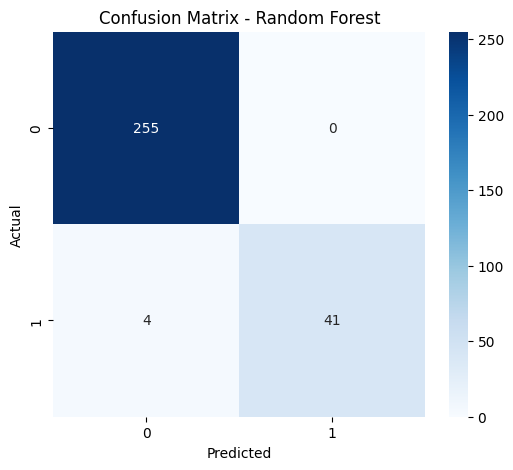

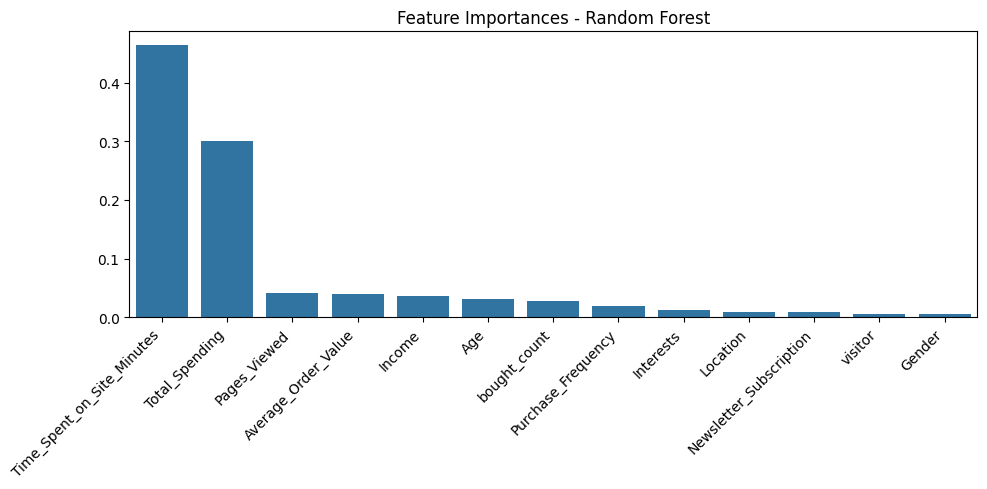

In [56]:
# Step 12: Confusion Matrix Visualization (Random Forest example)
rf = models["Random Forest"]
y_pred_rf = rf.predict(X_test)
conf_matrix = confusion_matrix(y_test, y_pred_rf)
plt.figure(figsize=(6, 5))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix - Random Forest')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

# Step 13 (Optional): Feature Importance Plot
importances = rf.feature_importances_
indices = np.argsort(importances)[::-1]
plt.figure(figsize=(10, 5))
sns.barplot(x=np.array(features)[indices], y=importances[indices])
plt.title('Feature Importances - Random Forest')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

CLUSTERING

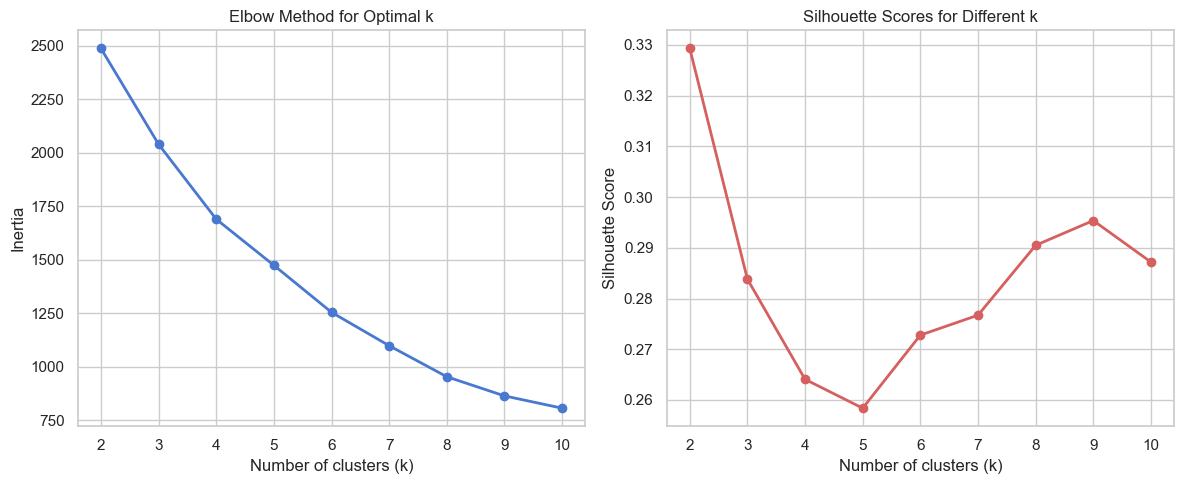

In [72]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt

# Select relevant features for clustering (scale them first)
cluster_features = ['Total_Spending', 'engagement_score', 'Time_Spent_on_Site_Minutes', 'Pages_Viewed']
X_cluster = df[cluster_features]

# Scale the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_cluster)

# Step 1: Elbow Method to find optimal k
inertia = []
silhouette = []
K = range(2, 11)  # try between 2 and 10 clusters

for k in K:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(X_scaled)
    inertia.append(kmeans.inertia_)
    silhouette.append(silhouette_score(X_scaled, kmeans.labels_))

# Plot Elbow Curve
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(K, inertia, 'bo-', linewidth=2)
plt.title('Elbow Method for Optimal k')
plt.xlabel('Number of clusters (k)')
plt.ylabel('Inertia')

# Plot Silhouette Scores
plt.subplot(1, 2, 2)
plt.plot(K, silhouette, 'ro-', linewidth=2)
plt.title('Silhouette Scores for Different k')
plt.xlabel('Number of clusters (k)')
plt.ylabel('Silhouette Score')
plt.tight_layout()
plt.show()

In [ ]:
optimal_k = K[silhouette.index(max(silhouette))]
print(f"Optimal number of clusters based on silhouette analysis: {optimal_k}")

# Step 3: Final K-Means with optimal k
kmeans_final = KMeans(n_clusters=optimal_k, random_state=42)
df['Cluster'] = kmeans_final.fit_predict(X_scaled)

Optimal number of clusters based on silhouette analysis: 2


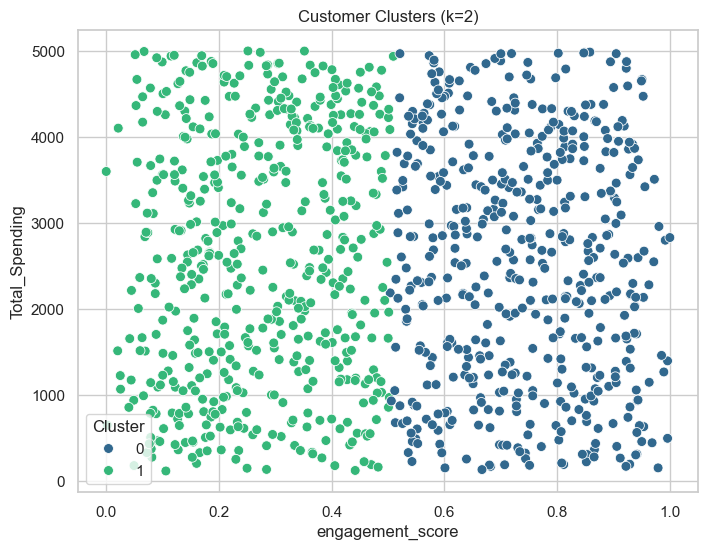


Cluster Summary (Mean Values per Cluster):
         Total_Spending  engagement_score  Time_Spent_on_Site_Minutes  \
Cluster                                                                 
0           2522.528455          0.740654                  451.961382   
1           2582.427165          0.272020                  147.627953   

         Pages_Viewed  
Cluster                
0           25.414634  
1           23.423228  


In [76]:
kmeans_final = KMeans(n_clusters=optimal_k, random_state=42)
df['Cluster'] = kmeans_final.fit_predict(X_scaled)

# Step 4: Visualize clusters
plt.figure(figsize=(8, 6))
sns.scatterplot(
    x='engagement_score', y='Total_Spending',
    hue='Cluster', palette='viridis', data=df, s=50
)
plt.title(f'Customer Clusters (k={optimal_k})')
plt.show()

# Step 5: Cluster Analysis Summary
cluster_summary = df.groupby('Cluster')[['Total_Spending', 'engagement_score', 'Time_Spent_on_Site_Minutes', 'Pages_Viewed']].mean()
print("\nCluster Summary (Mean Values per Cluster):")
print(cluster_summary)

In [77]:
from scipy.spatial.distance import cdist
import numpy as np

# Assuming:
# - X_scaled = your scaled feature matrix used for K-Means
# - kmeans_final = your trained KMeans model
# - df['Cluster'] = assigned cluster labels

# ---- WCSS (Within-Cluster Sum of Squares) ----
wcss = np.sum(np.min(cdist(X_scaled, kmeans_final.cluster_centers_, 'euclidean')**2, axis=1))
print(f"Total WCSS (Within-Cluster Sum of Squares): {wcss:.4f}")

# ---- Inter-Cluster Distances ----
centroids = kmeans_final.cluster_centers_
inter_cluster_distances = cdist(centroids, centroids, metric='euclidean')

# Clean up matrix for readability
inter_cluster_df = pd.DataFrame(
    inter_cluster_distances, 
    columns=[f"Cluster_{i}" for i in range(len(centroids))],
    index=[f"Cluster_{i}" for i in range(len(centroids))]
)
np.fill_diagonal(inter_cluster_df.values, np.nan)

print("\nInter-Cluster Distance Matrix:")
print(inter_cluster_df.round(3))

# ---- Summary Statistics ----
mean_inter_distance = np.nanmean(inter_cluster_df.values)
min_inter_distance = np.nanmin(inter_cluster_df.values)
max_inter_distance = np.nanmax(inter_cluster_df.values)

print(f"\nMean Inter-Cluster Distance: {mean_inter_distance:.4f}")
print(f"Minimum Inter-Cluster Distance: {min_inter_distance:.4f}")
print(f"Maximum Inter-Cluster Distance: {max_inter_distance:.4f}")

Total WCSS (Within-Cluster Sum of Squares): 2487.8829

Inter-Cluster Distance Matrix:
           Cluster_0  Cluster_1
Cluster_0        NaN       2.46
Cluster_1       2.46        NaN

Mean Inter-Cluster Distance: 2.4597
Minimum Inter-Cluster Distance: 2.4597
Maximum Inter-Cluster Distance: 2.4597


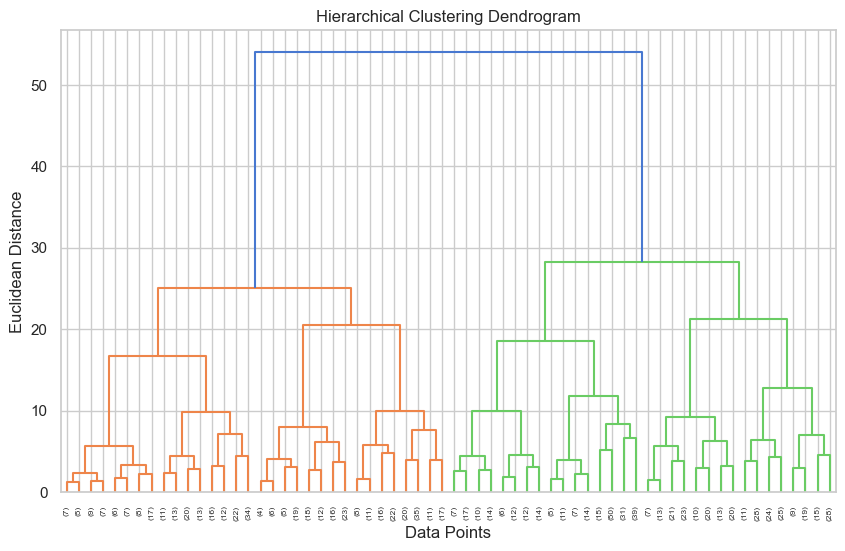

In [78]:
from scipy.cluster.hierarchy import linkage, dendrogram
import matplotlib.pyplot as plt

Z = linkage(X_scaled, method='ward')
plt.figure(figsize=(10, 6))
dendrogram(Z, truncate_mode='level', p=5)
plt.title('Hierarchical Clustering Dendrogram')
plt.xlabel('Data Points')
plt.ylabel('Euclidean Distance')
plt.show()

In [79]:
from sklearn.cluster import AgglomerativeClustering
agg = AgglomerativeClustering(n_clusters=3)
df['AggCluster'] = agg.fit_predict(X_scaled)

In [80]:
from sklearn.cluster import DBSCAN
dbscan = DBSCAN(eps=0.5, min_samples=5)
df['DBSCAN_Cluster'] = dbscan.fit_predict(X_scaled)
print(df['DBSCAN_Cluster'].value_counts())

DBSCAN_Cluster
 0    991
-1      9
Name: count, dtype: int64


In [81]:
from sklearn.mixture import GaussianMixture
gmm = GaussianMixture(n_components=3, random_state=42)
df['GMM_Cluster'] = gmm.fit_predict(X_scaled)

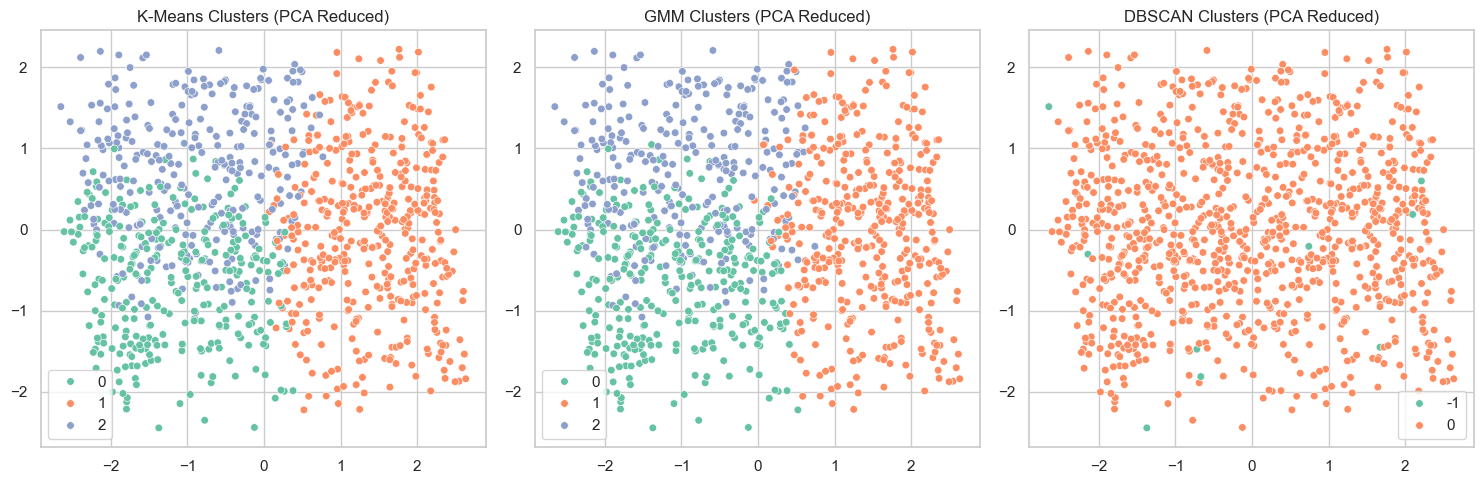

In [84]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns

pca = PCA(n_components=2)
reduced = pca.fit_transform(X_scaled)

fig, axes = plt.subplots(1, 3, figsize=(15, 5))
models = {
    'K-Means': labels_kmeans,
    'GMM': labels_gmm,
    'DBSCAN': labels_dbscan
}

for ax, (name, labels) in zip(axes, models.items()):
    sns.scatterplot(x=reduced[:,0], y=reduced[:,1], hue=labels, palette='Set2', ax=ax, s=30)
    ax.set_title(f'{name} Clusters (PCA Reduced)')
plt.tight_layout()
plt.show()

In [82]:
from sklearn.cluster import KMeans, DBSCAN
from sklearn.mixture import GaussianMixture
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score
import pandas as pd

results = []

# --- K-Means ---
kmeans = KMeans(n_clusters=3, random_state=42)
labels_kmeans = kmeans.fit_predict(X_scaled)
results.append({
    'Model': 'K-Means',
    'Silhouette': silhouette_score(X_scaled, labels_kmeans),
    'Davies-Bouldin': davies_bouldin_score(X_scaled, labels_kmeans),
    'Calinski-Harabasz': calinski_harabasz_score(X_scaled, labels_kmeans)
})

# --- Gaussian Mixture Model ---
gmm = GaussianMixture(n_components=3, random_state=42)
labels_gmm = gmm.fit_predict(X_scaled)
results.append({
    'Model': 'GMM',
    'Silhouette': silhouette_score(X_scaled, labels_gmm),
    'Davies-Bouldin': davies_bouldin_score(X_scaled, labels_gmm),
    'Calinski-Harabasz': calinski_harabasz_score(X_scaled, labels_gmm)
})

# --- DBSCAN ---
dbscan = DBSCAN(eps=0.5, min_samples=5)
labels_dbscan = dbscan.fit_predict(X_scaled)
# Only evaluate if DBSCAN forms valid clusters
if len(set(labels_dbscan)) > 1:
    results.append({
        'Model': 'DBSCAN',
        'Silhouette': silhouette_score(X_scaled, labels_dbscan),
        'Davies-Bouldin': davies_bouldin_score(X_scaled, labels_dbscan),
        'Calinski-Harabasz': calinski_harabasz_score(X_scaled, labels_dbscan)
    })
else:
    results.append({
        'Model': 'DBSCAN',
        'Silhouette': None,
        'Davies-Bouldin': None,
        'Calinski-Harabasz': None
    })

# --- Combine Results ---
comparison_df = pd.DataFrame(results)
print("\nClustering Model Comparison:\n")
print(comparison_df.round(3))


Clustering Model Comparison:

     Model  Silhouette  Davies-Bouldin  Calinski-Harabasz
0  K-Means       0.284           1.305            479.141
1      GMM       0.282           1.315            474.861
2   DBSCAN       0.132           4.137              2.290


We want segmentation => unsupervised => k means or gmm


📊 Ensemble Clustering Metrics:
Silhouette: 0.282
Davies-Bouldin: 1.310
Calinski-Harabasz: 475.695


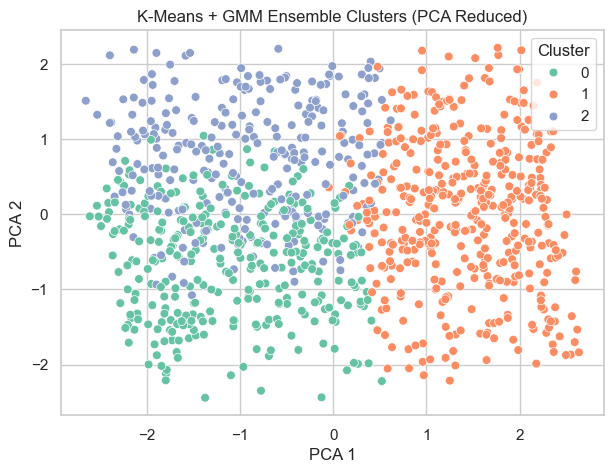

In [86]:
from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score
from sklearn.decomposition import PCA
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import mode
import numpy as np
import pandas as pd

# --- Fit models ---
kmeans = KMeans(n_clusters=3, random_state=42)
labels_kmeans = kmeans.fit_predict(X_scaled)

gmm = GaussianMixture(n_components=3, random_state=42)
labels_gmm = gmm.fit_predict(X_scaled)

# --- Ensemble via majority voting (fixed) ---
ensemble_labels = []
for k_label, g_label in zip(labels_kmeans, labels_gmm):
    # Mode returns a ModeResult object in new SciPy versions
    m = mode([k_label, g_label], keepdims=True)
    ensemble_labels.append(m.mode[0])
ensemble_labels = np.array(ensemble_labels)

# --- Evaluate ensemble performance ---
metrics = {
    'Silhouette': silhouette_score(X_scaled, ensemble_labels),
    'Davies-Bouldin': davies_bouldin_score(X_scaled, ensemble_labels),
    'Calinski-Harabasz': calinski_harabasz_score(X_scaled, ensemble_labels)
}

print("\n📊 Ensemble Clustering Metrics:")
for k, v in metrics.items():
    print(f"{k}: {v:.3f}")

# --- Visualize ---
pca = PCA(n_components=2)
reduced = pca.fit_transform(X_scaled)

plt.figure(figsize=(7, 5))
sns.scatterplot(x=reduced[:, 0], y=reduced[:, 1], hue=ensemble_labels, palette='Set2', s=40)
plt.title('K-Means + GMM Ensemble Clusters (PCA Reduced)')
plt.xlabel('PCA 1')
plt.ylabel('PCA 2')
plt.legend(title='Cluster')
plt.show()
